In [5]:
#library for understanding music
from music21 import *

# Reading Musical Files:

Let’s define a function straight away for reading the MIDI files. It returns the array of notes and chords present in the musical file.

In [7]:
#defining function to read MIDI files
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

Now, we will load the MIDI files into our environment

In [9]:
#for listing down the file names
import os

#Array Processing
import numpy as np

#specify the path
path='schubert/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

Loading Music File: schubert/schubert_D850_1.mid
Loading Music File: schubert/schubert_D850_2.mid
Loading Music File: schubert/schubert_D850_3.mid
Loading Music File: schubert/schubert_D850_4.mid
Loading Music File: schubert/schubert_D935_1.mid
Loading Music File: schubert/schubert_D935_2.mid
Loading Music File: schubert/schubert_D935_3.mid
Loading Music File: schubert/schubert_D935_4.mid
Loading Music File: schubert/schub_d760_1.mid
Loading Music File: schubert/schub_d760_2.mid
Loading Music File: schubert/schub_d760_3.mid
Loading Music File: schubert/schub_d760_4.mid
Loading Music File: schubert/schub_d960_1.mid
Loading Music File: schubert/schub_d960_2.mid
Loading Music File: schubert/schub_d960_3.mid
Loading Music File: schubert/schub_d960_4.mid
Loading Music File: schubert/schuim-1.mid
Loading Music File: schubert/schuim-2.mid
Loading Music File: schubert/schuim-3.mid
Loading Music File: schubert/schuim-4.mid
Loading Music File: schubert/schumm-1.mid
Loading Music File: schubert/s

<ipython-input-9-13269b8794bc>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  notes_array = np.array([read_midi(path+i) for i in files])


Understanding the data:

Under this section, we will explore the dataset and understand it in detail.

In [10]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

345


Now, let us see the distribution of the notes.

(array([221.,  40.,  31.,  13.,   8.,   3.,   7.,   9.,   7.,   6.]),
 array([1.0000e+00, 1.6170e+02, 3.2240e+02, 4.8310e+02, 6.4380e+02,
        8.0450e+02, 9.6520e+02, 1.1259e+03, 1.2866e+03, 1.4473e+03,
        1.6080e+03]),
 <BarContainer object of 10 artists>)

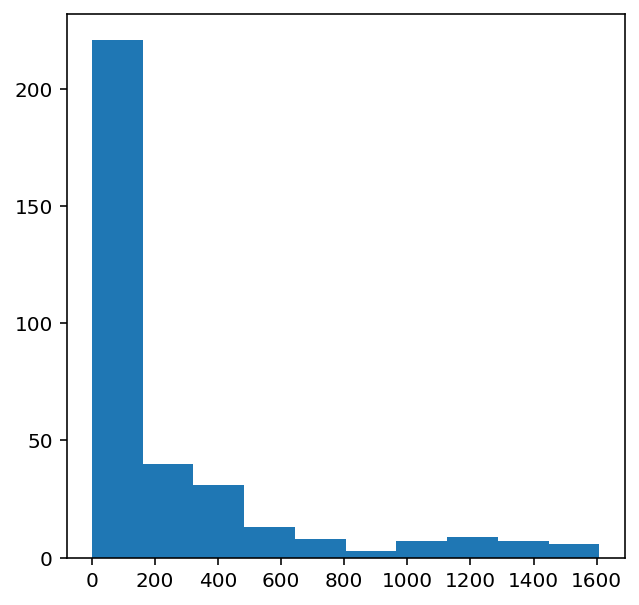

In [12]:
#importing library
from collections import Counter

#computing frequency of each note
freq = dict(Counter(notes_))

#library for visualiation
import matplotlib.pyplot as plt

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

From the above plot, we can infer that most of the notes have a very low frequency. So, let us keep the top frequent notes and ignore the low-frequency ones. Here, I am defining the threshold as 50. Nevertheless, the parameter can be changed.

In [14]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

182


As you can see here, no. of frequently occurring notes is around 170.  Now, let us prepare new musical files which contain only the top frequent notes

In [17]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music, dtype=object)

Preparing Data:

Preparing the input and output sequences as mentioned in the article:

In [19]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

Now, we will assign a unique integer to every note:

In [21]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

We will prepare the integer sequences for input data

In [23]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

Similarly, prepare the integer sequences for output data as well

In [25]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

Let us preserve 80% of the data for training and the rest 20% for the evaluation:

In [27]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

Model Building

I have defined 2 architectures here – WaveNet and LSTM. Please experiment with both the architectures to understand the importance of WaveNet architecture.

In [30]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           18200     
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            19264     
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 128)            0

Define the callback to save the best model during training:

In [32]:
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

Let’s train the model with a batch size of 128 for 50 epochs:

In [34]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

Epoch 1/50
492/492 [==============================] - 69s 140ms/step - loss: 2.5916 - val_loss: 3.1134

Epoch 00001: val_loss improved from 3.11942 to 3.11343, saving model to best_model.h5
Epoch 2/50
492/492 [==============================] - 67s 135ms/step - loss: 2.5995 - val_loss: 3.1229

Epoch 00002: val_loss did not improve from 3.11343
Epoch 3/50
492/492 [==============================] - 72s 146ms/step - loss: 2.5922 - val_loss: 3.1169

Epoch 00003: val_loss did not improve from 3.11343
Epoch 4/50
492/492 [==============================] - 63s 129ms/step - loss: 2.5832 - val_loss: 3.1237

Epoch 00004: val_loss did not improve from 3.11343
Epoch 5/50
492/492 [==============================] - 58s 119ms/step - loss: 2.5823 - val_loss: 3.1114

Epoch 00005: val_loss improved from 3.11343 to 3.11139, saving model to best_model.h5
Epoch 6/50
492/492 [==============================] - 58s 117ms/step - loss: 2.5754 - val_loss: 3.1311

Epoch 00006: val_loss did not improve from 3.11139


In [36]:
#loading best model
from keras.models import load_model
model = load_model('best_model.h5')

Its time to compose our own music now. We will follow the steps mentioned under the inference phase for the predictions.

In [49]:
import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

[130, 173, 130, 173, 130, 173, 130, 173, 130, 173]


Now, we will convert the integers back into the notes.

In [50]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

The final step is to convert back the predictions into a MIDI file. Let’s define the function to accomplish the task.

In [51]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

Converting the predictions into a musical file:

In [52]:
convert_to_midi(predicted_notes)